In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline

/home/jack/miniconda3/envs/instree/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
revision  = None
train_data_dir = "input_concepts/canada_bear/v0"
resolution = 512
placeholder_token = "<*> <&>"
repeats = 100
learnable_property = 'object'
center_crop = False
train_batch_size = 2
dataloader_num_workers = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
weight_dtype = torch.float32

In [3]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [4]:
# Load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)

pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False).to(device)
text_encoder.to(device)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 336441.50it/s]


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [5]:
def run_prompt(pipe, prompt, num_images_per_seed, seed=0):
    with torch.no_grad():
        torch.manual_seed(seed)
        images = pipe(prompt=[prompt] * num_images_per_seed, num_inference_steps=25, guidance_scale=7.5).images
        np_images = np.hstack([np.asarray(img) for img in images])
        plt.figure(figsize=(10,10))
        plt.imshow(np_images)
        plt.axis("off")
        plt.title(prompt)
        plt.show()

100%|██████████| 25/25 [00:04<00:00,  5.67it/s]


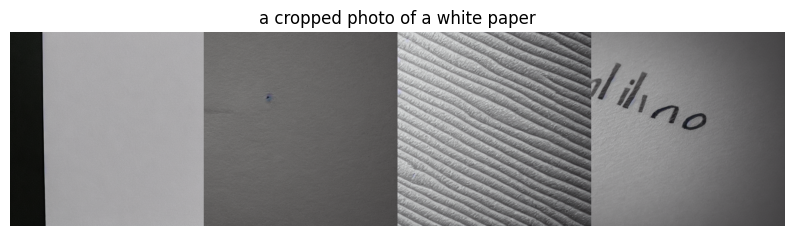

In [11]:
prompt = random.choice(imagenet_templates_small).format("white paper")
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed)

100%|██████████| 25/25 [00:05<00:00,  4.72it/s]


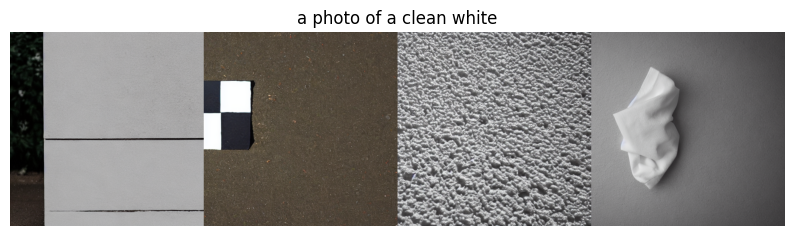

In [7]:
prompt = random.choice(imagenet_templates_small).format("white")
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed)

100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


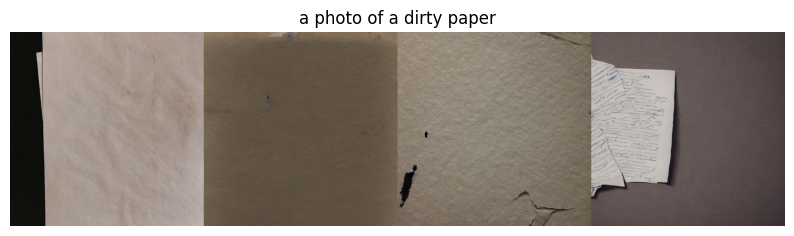

In [8]:
prompt = random.choice(imagenet_templates_small).format("paper")
num_images_per_seed = 4
run_prompt(pipe, prompt, num_images_per_seed)

In [55]:
# Read from trained results
import os
import utils

root_concept = "white_cat"
learned_tokens_dir = f"input_concepts/{root_concept}"
learned_nodes = sorted(os.listdir(learned_tokens_dir))
all_nodes = {}
print(f"Loading learned nodes from {learned_nodes}...")
for node in learned_nodes:
    if os.path.exists(f"{learned_tokens_dir}/{node}/embeds.bin"):
        node_code = torch.load(f"{learned_tokens_dir}/{node}/embeds.bin")[node]
        all_nodes[f"<{node}>"] = node_code

utils.load_tokens(pipe, all_nodes, device)
print("Prompts loaded to pipe ...")
print(all_nodes.keys())

Loading learned nodes from ['v0', 'v1', 'v2']...
Prompts loaded to pipe ...
dict_keys(['<v1>', '<v2>'])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


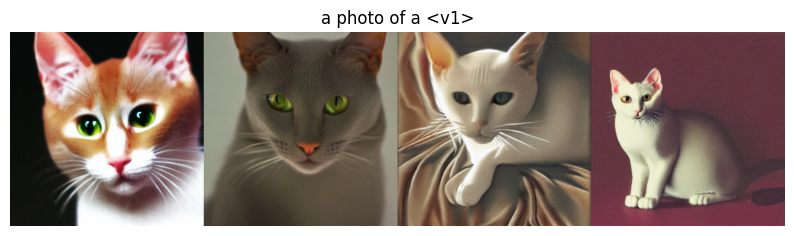

In [56]:
run_prompt(pipe, "a photo of a <v1>", 4)

100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


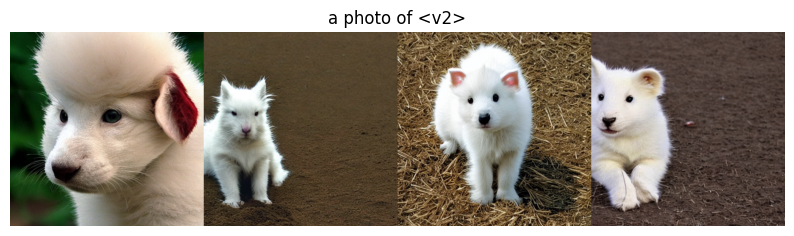

In [59]:
run_prompt(pipe, "a photo of <v2>", 4)

In [7]:
token = tokenizer.convert_ids_to_tokens(2802)
token

'paper</w>'

In [8]:
token_embeds = text_encoder.get_input_embeddings().weight
token_embeds.shape

torch.Size([49408, 768])

In [9]:
word = 'dog'
word_emb = token_embeds[tokenizer.encode(word, add_special_tokens=False)[0]]
# word_emb = get_word_embedding(word)
# word_emb = text_encoder(torch.tensor([[36662]]).to(device))[0][0][0]
# print(tokenizer(word).input_ids)

def find_closest_words(emb, k=10):
    token_embeds = text_encoder.get_input_embeddings().weight
    token_embeds = F.normalize(token_embeds, p=2, dim=1)
    emb = F.normalize(emb, p=2, dim=0)
    distances = torch.matmul(token_embeds, emb)
    closest = distances.argsort(descending=True)
    top_words = tokenizer.convert_ids_to_tokens(closest[:k])
    top_sim = distances[closest[:k]]
    result = []
    for i in range(k):
        result.append((top_words[i], top_sim[i].item()))
    return result

find_closest_words(word_emb)

[('dog</w>', 1.0),
 ('dogs</w>', 0.6508423686027527),
 ('dog', 0.5703340172767639),
 ('cat</w>', 0.33908095955848694),
 ('dawg</w>', 0.3307395875453949),
 ('doggy</w>', 0.30392321944236755),
 ('dogs', 0.2836660146713257),
 ('puppy</w>', 0.2826126515865326),
 ('dogg</w>', 0.2738196849822998),
 ('doggo</w>', 0.265274316072464)]

In [11]:
concept = "white_cat_square"
base_path = "/home/jack/Code/Projects/inspiration_tree/outputs/"
emb_path = f"{concept}/v0/v0_seed111/learned_embeds-steps-1000.bin"

# Load embeddings
learned_embeds = torch.load(base_path + emb_path, map_location=device)
for k in learned_embeds.keys():
    print(learned_embeds[k].shape)
    print(k, [x[0] for x in find_closest_words(learned_embeds[k])])

torch.Size([768])
<*> ['mammals</w>', 'reliability</w>', 'gateshead</w>', 'panthers</w>', 'footprint</w>', 'optimized</w>', 'counterpart</w>', 'toddler</w>', 'redcarpet</w>', 'nbafinals</w>']
torch.Size([768])
<&> ['cougars</w>', 'compati', 'textbooks</w>', 'reaper</w>', 'hotspot</w>', 'mored</w>', 'obsolete</w>', 'totals</w>', 'internetofthings</w>', 'amarketing</w>']


In [88]:
def get_embedding(sentence):
    input_id = tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids[0].unsqueeze(0).to(device)
    # print(sentence)
    # print(example["input_ids"]) # [1, 77]
    return text_encoder(input_id)[0] #, position_ids=torch.tensor([[0]*77]).to(device))[0]

def get_word_embedding(word):
    embed = get_embedding(word)
    return embed[0, 1, :]

def get_null_embedding(batch_size=2):
    out = []
    for _ in range(batch_size):
        out.append(get_embedding(""))
    return torch.cat(out, dim=0)

def get_sentence_embedding(sentence, batch_size=2):
    out = []
    for _ in range(batch_size):
        text = random.choice(imagenet_templates_small).format(sentence)
        out.append(get_embedding(text))
    return torch.cat(out, dim=0)

print(get_word_embedding('dog').shape) # 768
print(get_null_embedding().shape) # bs x 77 x 768, 77 = <bos> + <eos> * 76
print(get_sentence_embedding("dog").shape) # bs x 77 x 768

torch.Size([768])
torch.Size([2, 77, 768])
torch.Size([2, 77, 768])


In [7]:
torch.load(f'assets/paper_tokens.bin').keys()

dict_keys(['cat', 'bear', 'buddha', 'mug', 'teapot', 'round_bird', 'elephant', 'wooden_pot', 'physics_mug', 'red_teapot', 'mug_buildings'])